In [1]:
import gc
from collections import defaultdict
from itertools import combinations
from pprint import pprint

import matplotlib.pyplot as plt
import networkx as nx
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn.image import load_img, math_img, new_img_like
from nilearn.plotting import plot_roi, plot_stat_map
from scipy.ndimage import label
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from survey_medley_code.config_loader import load_config

# What is this?
Prior analyses using PCA focused on questionnaire averages, but since those activation maps have very similar spatial patterns the PCA wasn't very informative.  Since the pairwise comparison maps do exhibit different spatial patterns, a PCA may be more informative in this case.

PCA across the pairwise maps identifies the main spatial patterns in which the contrasts differ, summarizing how groups of voxels vary together across all pairwise comparisons.  


## Note on PCA of 10 pairwise maps vs 5 questionnaire-activation maps (vs baseline)
When running PCA on the raw questionnaire maps, the strong shared activation across all questionnaires dominates the variance, so subtle differences driven by a single questionnaire are buried and do not appear in the leading PCs. In contrast, PCA on pairwise difference maps highlights contrasts between questionnaires, allowing patterns dominated by a single questionnaire to emerge clearly as a principal component.

I mention this because you will see PC2 appears to primarily reflect contrasts involving impulsive_venture, revealing a pattern that did not emerge in the PCA on the 5 raw questionnaire maps.

## Note on PCA vs F-test

This PCA analysis does not directly reflect the voxelwise F-test results. The F-test is univariate: it evaluates each voxel independently to see if there is a significant difference across conditions. In contrast, PCA is multivariate: it identifies spatial patterns of covarying differences across multiple contrasts.

* Implication: A voxel may appear important in a PC map (strongly contributes to a pattern) even if it is not significant in the F-test, and vice versa.
* PCA captures distributed patterns that summarize how contrasts relate across the brain, whereas the F-test captures localized, voxelwise effects.
* Potential overlap: In some cases, if a voxel strongly drives differences across multiple contrasts, it might appear in both the F-test and a prominent PC—but this is incidental, not guaranteed.

Bottom line: PCA is a descriptive, multivariate tool for exploring patterns of variation across contrasts, not a substitute for statistical inference from F-tests.

## Adjusted vs Unadjusted analyses
There are two sets of results, in one set the question-specific estimates are not adjusted for the character count of the question, while the adjusted results used questionnaire average estimates that were adjusted for the character counts of the individual questions.  As you'll see the results barely change at all, indicating there was not a noticeable confounding effect of question length on this analysis.

# PCA Brain Map Interpretation Cheat Sheet

Each Principal Component (PC) summarizes patterns across the pairwise comparison t-maps:

$PC score (voxel) = \sum_i (loading_i * tvoxel_i)$

- Voxel score → how strongly the voxel expresses the PC pattern  
- Loading → how much each contrast contributes to the PC  

## Interpreting contrast direction
For contrast A-B:

Voxel × Loading   | Interpretation
----------------- | --------------
`+ × +`           | A > B
`- × +`           | A < B
`+ × -`           | A < B
`- × -`           | A > B


## Step-by-step

1. Check voxel score:  
   - Positive → aligns with PC pattern  
   - Negative → opposes PC pattern  

2. Check contrast loading:  
   - Positive → contributes positively  
   - Negative → contributes negatively  

3. Combine voxel × loading to infer the contrast direction (see table).  

> Magnitude of voxel score indicates strength of pattern expression.

## Example

PC1 loadings: A-B=0.54, C-D=-0.33, E-F=0.21

- Voxel X: PC1 score = +2.0  
  - A-B: + × + = A>B  
  - C-D: + × - = C<D  
  - E-F: + × + = E>F  

- Voxel Y: PC1 score = -1.5  
  - A-B: - × + = A<B  
  - C-D: - × - = C>D  
  - E-F: - × + = E<F$

In [2]:
cfg = load_config()

outdir = cfg.output_root / 'within_subject_question_estimates'
adjusted_outdir = cfg.output_root / 'within_subject_adjusted_questionnaire_averages'

paired_outdir = outdir / 'all_paired_t_tests'
adjusted_paired_outdir = adjusted_outdir / 'all_paired_t_tests'

In [3]:
brain_mask_file = (
    cfg.output_root / 'assess_subject_bold_dropout/group_mask_intersection_30pct.nii.gz'
)


In [4]:
questionnaire_names = ['brief', 'future_time', 'grit', 'impulsive_venture', 'upps']

question_pmaps = {}
question_tmaps = {}

for qa, qb in combinations(questionnaire_names, 2):
    pairing_name = f'{qa}_minus_{qb}'
    paired_pmap_loop = (
        paired_outdir
        / f'paired_test_{pairing_name}/onesample_2sided_tfce_corrp_fstat1.nii.gz'
    )
    paired_t_loop = (
        paired_outdir / f'paired_test_{pairing_name}/uncorrected_tstat1.nii.gz'
    )

    question_pmaps[pairing_name] = paired_pmap_loop
    question_tmaps[pairing_name] = paired_t_loop

In [5]:
# Load brain mask
mask_nifti = nib.load(str(brain_mask_file))
brain_mask = mask_nifti.get_fdata()

# Precompute mask indices
mask_idx = np.where(brain_mask)

contrast_names = list(question_tmaps.keys())
n_contrasts = len(contrast_names)

# Initialize matrix V×10
V = len(mask_idx[0])
vox_by_contrast = np.zeros((V, n_contrasts), dtype=np.float32)

for j, cname in enumerate(contrast_names):
    img = nib.load(str(question_tmaps[cname]))
    data = img.get_fdata()
    vox_by_contrast[:, j] = data[mask_idx]

print(vox_by_contrast.shape)

(178726, 10)


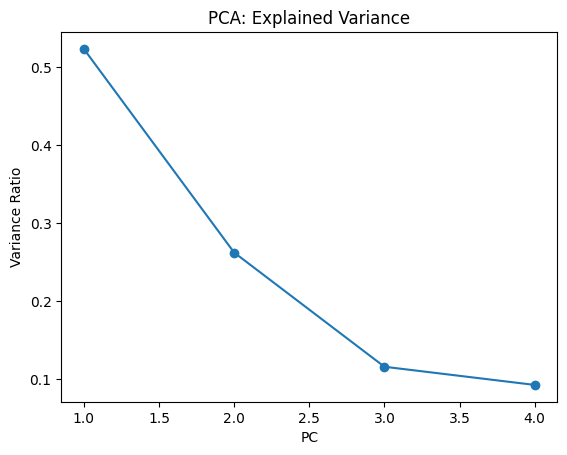

In [6]:
# Unscaled PCA
X_unscaled = vox_by_contrast.copy()

# -----------------------------
# Run PCA
# -----------------------------
n_components = 4  # adjust as needed

# Unscaled PCA
pca_unscaled = PCA(n_components=n_components)
scores_unscaled = pca_unscaled.fit_transform(X_unscaled)
loadings_unscaled = pca_unscaled.components_


# -----------------------------
# Scree plots
# -----------------------------

plt.plot(np.arange(1, n_components + 1), pca_unscaled.explained_variance_ratio_, 'o-')
plt.title('PCA: Explained Variance')
plt.xlabel('PC')
plt.ylabel('Variance Ratio')
plt.show()


In [7]:
loadings_df = pd.DataFrame(
    loadings_unscaled,
    index=[f'PC{i + 1}' for i in range(loadings_unscaled.shape[0])],
    columns=contrast_names,
)

print(loadings_df.T)

                                          PC1       PC2       PC3       PC4
brief_minus_future_time             -0.015190  0.016532  0.419951 -0.546622
brief_minus_grit                     0.093386  0.029312  0.701768  0.126041
brief_minus_impulsive_venture        0.370006 -0.369441  0.226104 -0.136620
brief_minus_upps                     0.498153  0.318532  0.233633 -0.174797
future_time_minus_grit               0.098146  0.012115  0.220465  0.625085
future_time_minus_impulsive_venture  0.383796 -0.359158 -0.077329  0.249163
future_time_minus_upps               0.454215  0.277107 -0.128115  0.271666
grit_minus_impulsive_venture         0.313781 -0.380073 -0.234138 -0.223182
grit_minus_upps                      0.379655  0.259362 -0.313614 -0.244171
impulsive_venture_minus_upps         0.012138  0.585888 -0.035830 -0.007362


## Repeat with the adjusted questionnaire estimates
I estimated the questionnaire averages, adjusting for the number of characters.  The goal is to see whether these results differ from the ones above (unadjusted)

In [8]:
questionnaire_names = ['brief', 'future_time', 'grit', 'impulsive_venture', 'upps']

adjusted_question_pmaps = {}
adjusted_question_tmaps = {}

for qa, qb in combinations(questionnaire_names, 2):
    pairing_name = f'{qa}_minus_{qb}'
    paired_pmap_loop = (
        adjusted_paired_outdir
        / f'paired_test_{pairing_name}/onesample_2sided_tfce_corrp_fstat1.nii.gz'
    )
    paired_t_loop = (
        adjusted_paired_outdir / f'paired_test_{pairing_name}/uncorrected_tstat1.nii.gz'
    )

    adjusted_question_pmaps[pairing_name] = paired_pmap_loop
    adjusted_question_tmaps[pairing_name] = paired_t_loop

In [9]:
adjusted_contrast_names = list(adjusted_question_tmaps.keys())
n_contrasts = len(adjusted_contrast_names)

# Initialize matrix V×10
V = len(mask_idx[0])
adjusted_vox_by_contrast = np.zeros((V, n_contrasts), dtype=np.float32)

for j, cname in enumerate(adjusted_contrast_names):
    img = nib.load(str(adjusted_question_tmaps[cname]))
    data = img.get_fdata()
    adjusted_vox_by_contrast[:, j] = data[mask_idx]

print(adjusted_vox_by_contrast.shape)

(178726, 10)


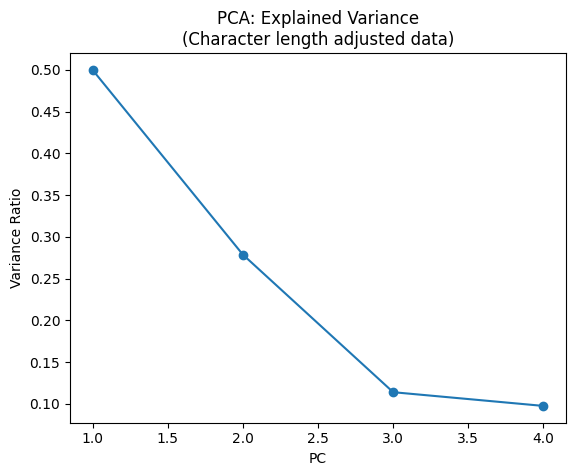

In [10]:
# Unscaled PCA
X_unscaled_adjusted = adjusted_vox_by_contrast.copy()

# -----------------------------
# Run PCA
# -----------------------------
n_components = 4  # adjust as needed

# Unscaled PCA
pca_unscaled_adjusted = PCA(n_components=n_components)
scores_unscaled_adjusted = pca_unscaled_adjusted.fit_transform(X_unscaled_adjusted)
loadings_unscaled_adjusted = pca_unscaled_adjusted.components_


# -----------------------------
# Scree plots
# -----------------------------

plt.plot(
    np.arange(1, n_components + 1),
    pca_unscaled_adjusted.explained_variance_ratio_,
    'o-',
)
plt.title('PCA: Explained Variance\n(Character length adjusted data)')
plt.xlabel('PC')
plt.ylabel('Variance Ratio')
plt.show()


In [11]:
loadings_df_adjusted = pd.DataFrame(
    loadings_unscaled_adjusted,
    index=[f'PC{i + 1}' for i in range(loadings_unscaled.shape[0])],
    columns=contrast_names,
)

print(loadings_df.T)

                                          PC1       PC2       PC3       PC4
brief_minus_future_time             -0.015190  0.016532  0.419951 -0.546622
brief_minus_grit                     0.093386  0.029312  0.701768  0.126041
brief_minus_impulsive_venture        0.370006 -0.369441  0.226104 -0.136620
brief_minus_upps                     0.498153  0.318532  0.233633 -0.174797
future_time_minus_grit               0.098146  0.012115  0.220465  0.625085
future_time_minus_impulsive_venture  0.383796 -0.359158 -0.077329  0.249163
future_time_minus_upps               0.454215  0.277107 -0.128115  0.271666
grit_minus_impulsive_venture         0.313781 -0.380073 -0.234138 -0.223182
grit_minus_upps                      0.379655  0.259362 -0.313614 -0.244171
impulsive_venture_minus_upps         0.012138  0.585888 -0.035830 -0.007362


### Note about sign flipping
You'll notice the sign of the weight flips for the 4th component, but the PC maps also flips signs.  Therefore the interpretations end up being the same.

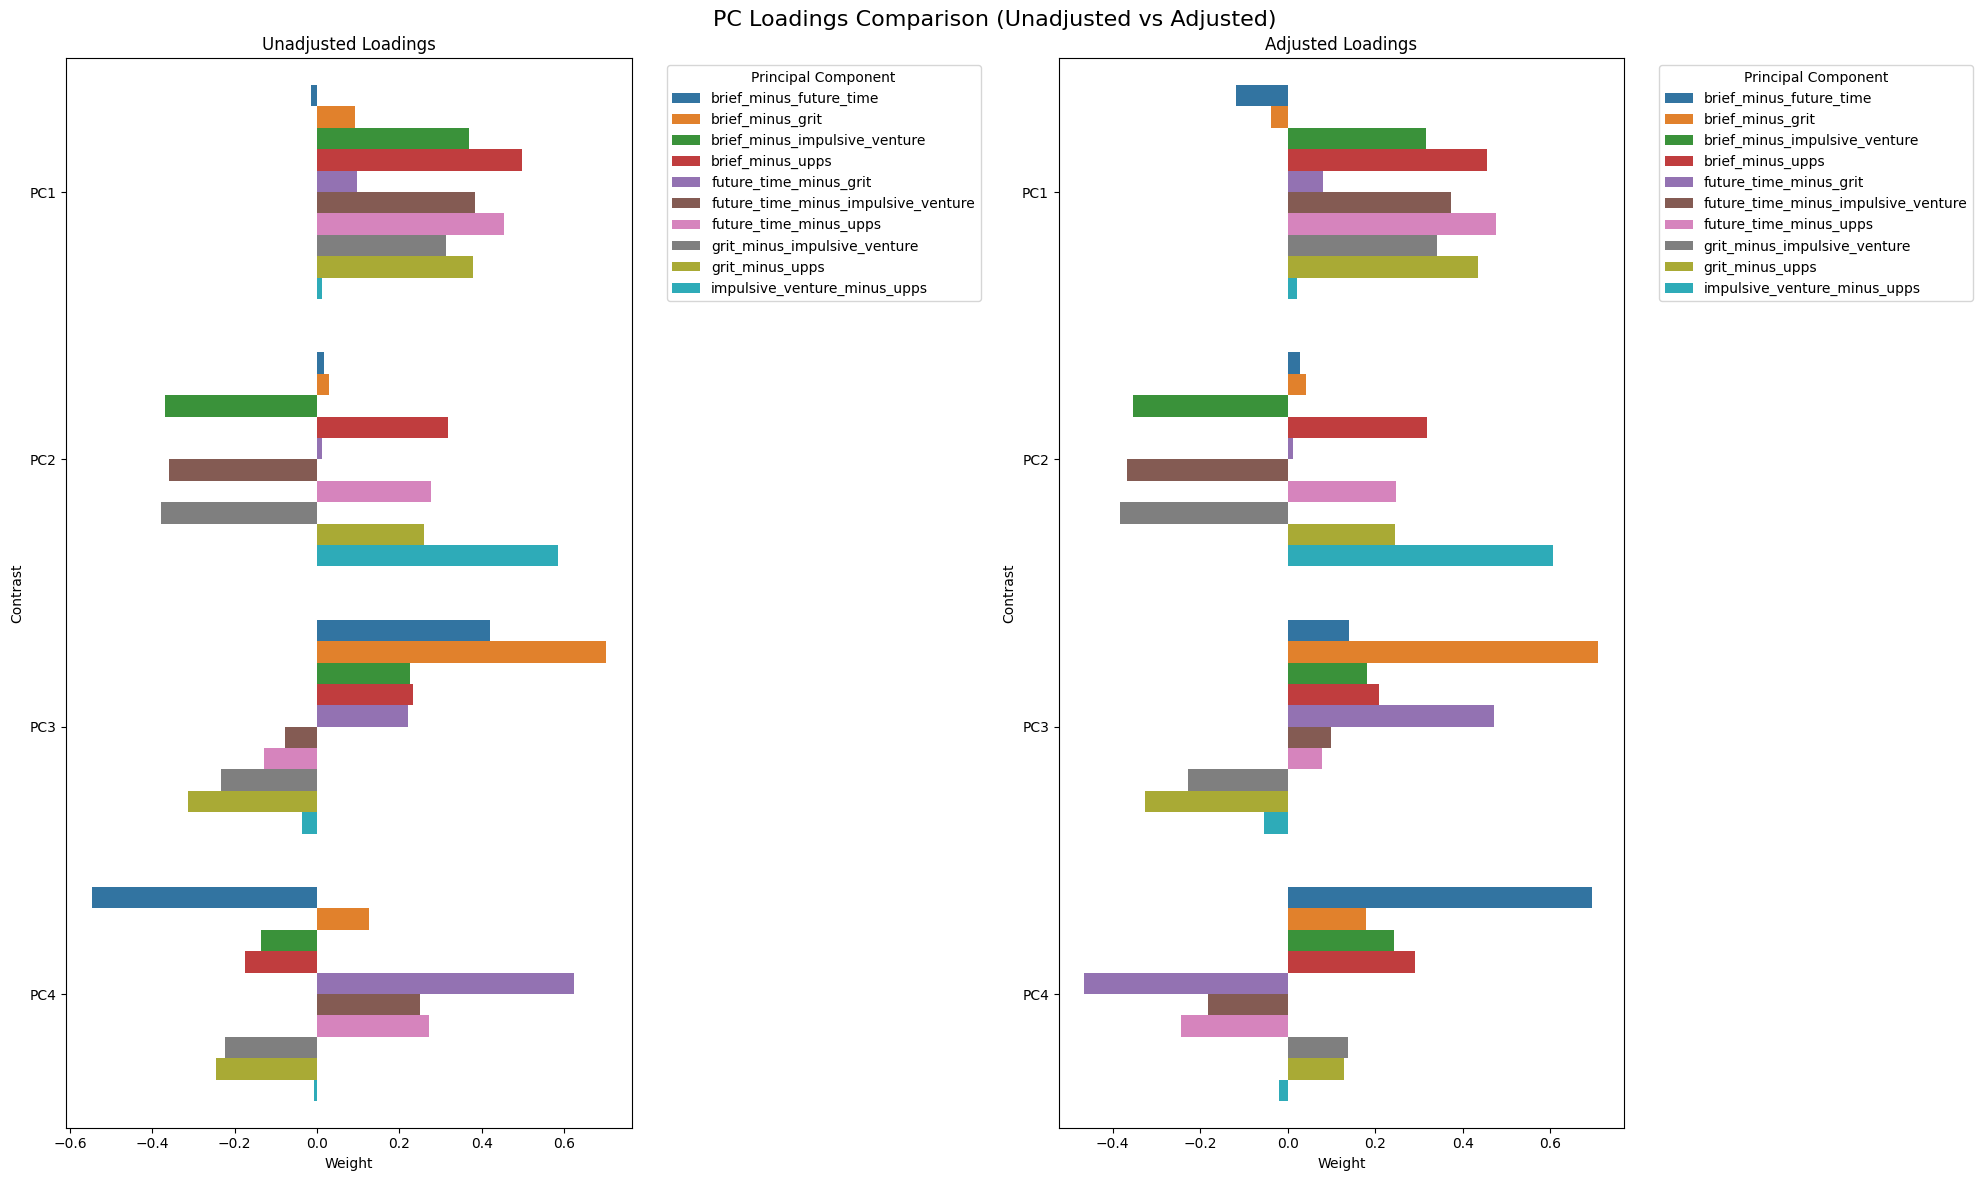

In [12]:
# Melt the dataframes to long format
loadings_melted = pd.melt(
    loadings_df.reset_index(), id_vars='index', var_name='PC', value_name='Loading'
)
loadings_adjusted_melted = pd.melt(
    loadings_df_adjusted.reset_index(),
    id_vars='index',
    var_name='PC',
    value_name='Loading',
)

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
fig.suptitle('PC Loadings Comparison (Unadjusted vs Adjusted)', fontsize=16)

# Plot for unadjusted loadings
sns.barplot(x='Loading', y='index', hue='PC', data=loadings_melted, ax=ax1)
ax1.set_title('Unadjusted Loadings')
ax1.set_xlabel('Weight')
ax1.set_ylabel('Contrast')
ax1.legend(title='Principal Component', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for adjusted loadings
sns.barplot(x='Loading', y='index', hue='PC', data=loadings_adjusted_melted, ax=ax2)
ax2.set_title('Adjusted Loadings')
ax2.set_xlabel('Weight')
ax2.set_ylabel('Contrast')
ax2.legend(title='Principal Component', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and display
plt.tight_layout()
plt.show()

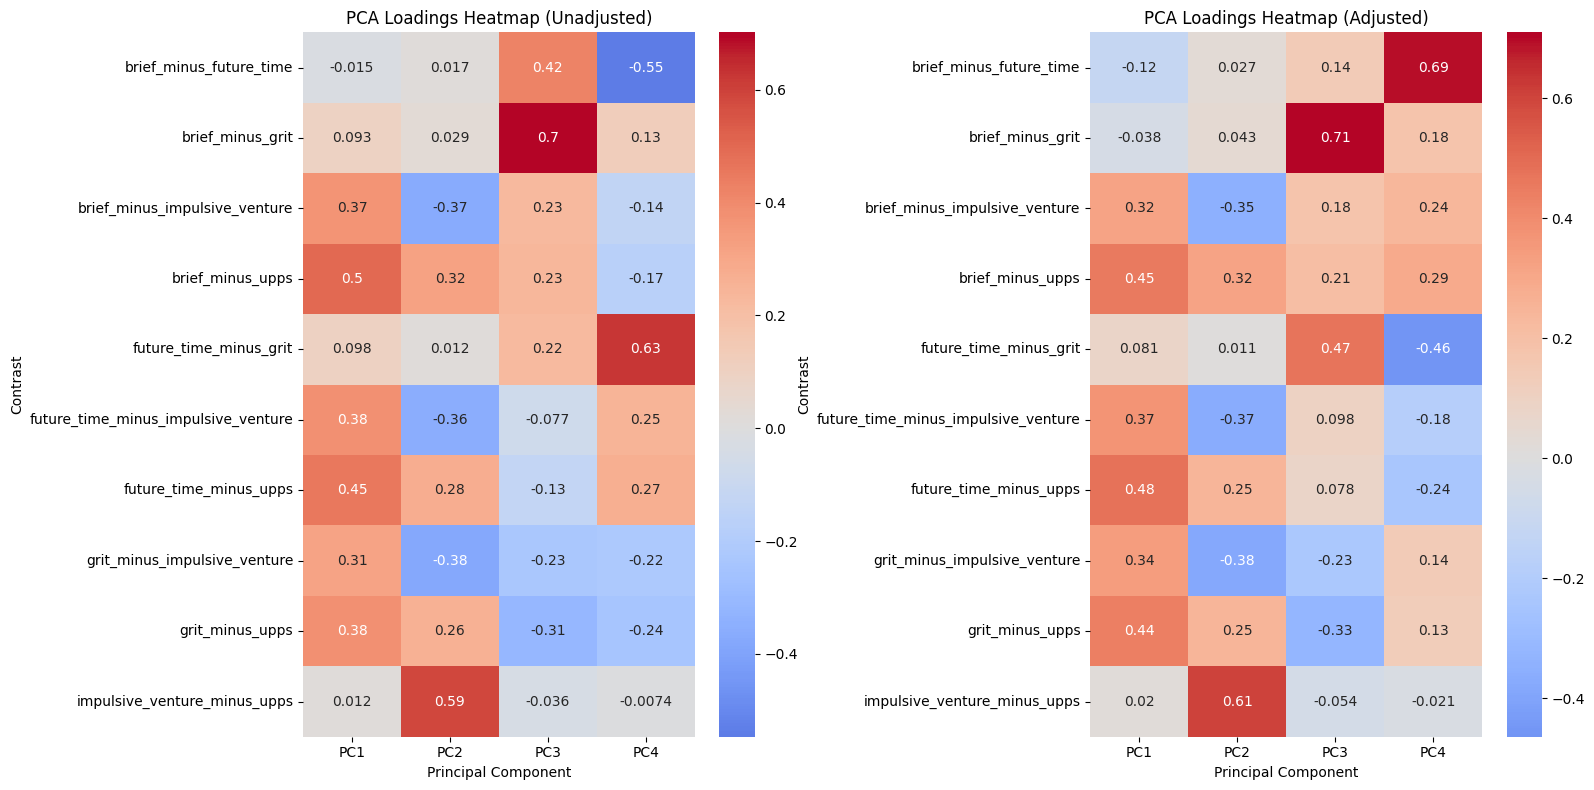

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First subplot (Unadjusted)
sns.heatmap(
    loadings_unscaled.T,
    annot=True,
    cmap='coolwarm',
    xticklabels=[f'PC{i + 1}' for i in range(loadings_unscaled.shape[0])],
    yticklabels=contrast_names,
    center=0,
    ax=ax1,
)
ax1.set_title('PCA Loadings Heatmap (Unadjusted)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Contrast')

# Second subplot (Adjusted)
sns.heatmap(
    loadings_unscaled_adjusted.T,
    annot=True,
    cmap='coolwarm',
    xticklabels=[f'PC{i + 1}' for i in range(loadings_unscaled.shape[0])],
    yticklabels=contrast_names,
    center=0,
    ax=ax2,
)
ax2.set_title('PCA Loadings Heatmap (Adjusted)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Contrast')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

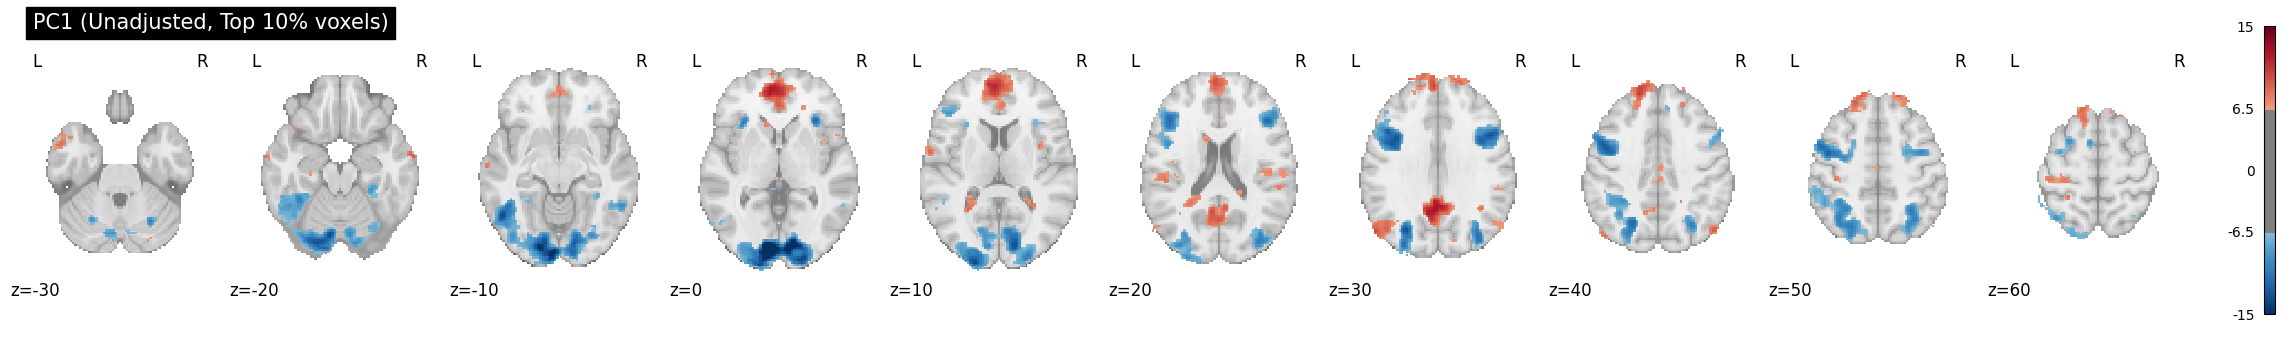

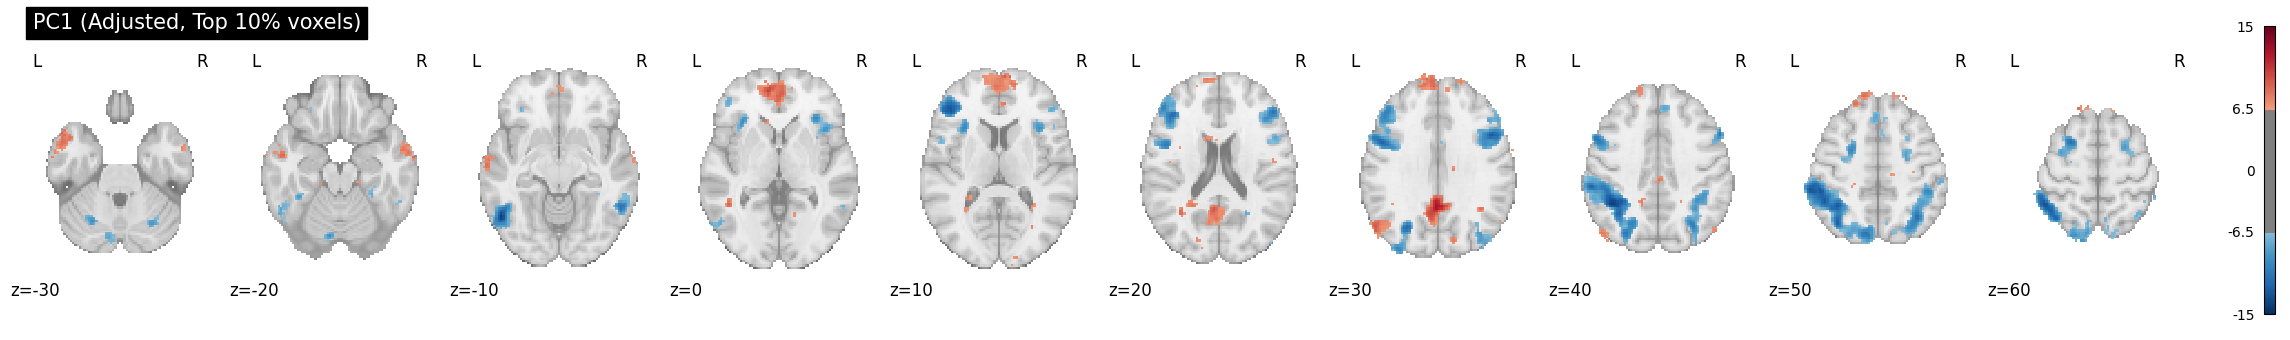

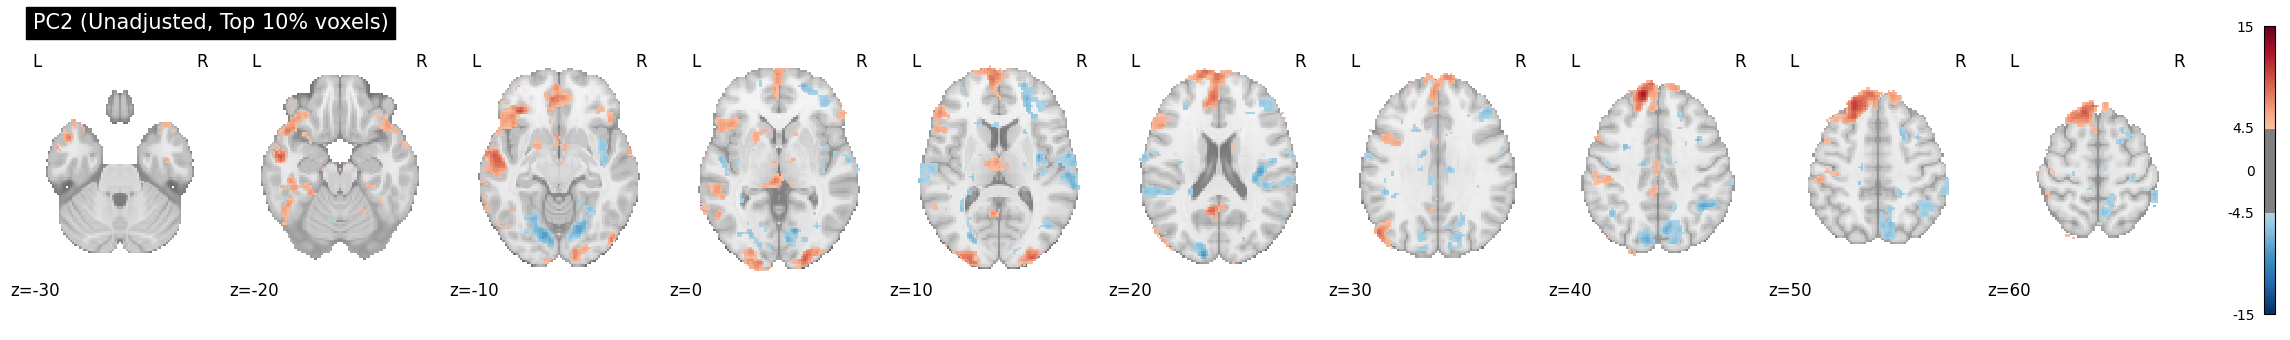

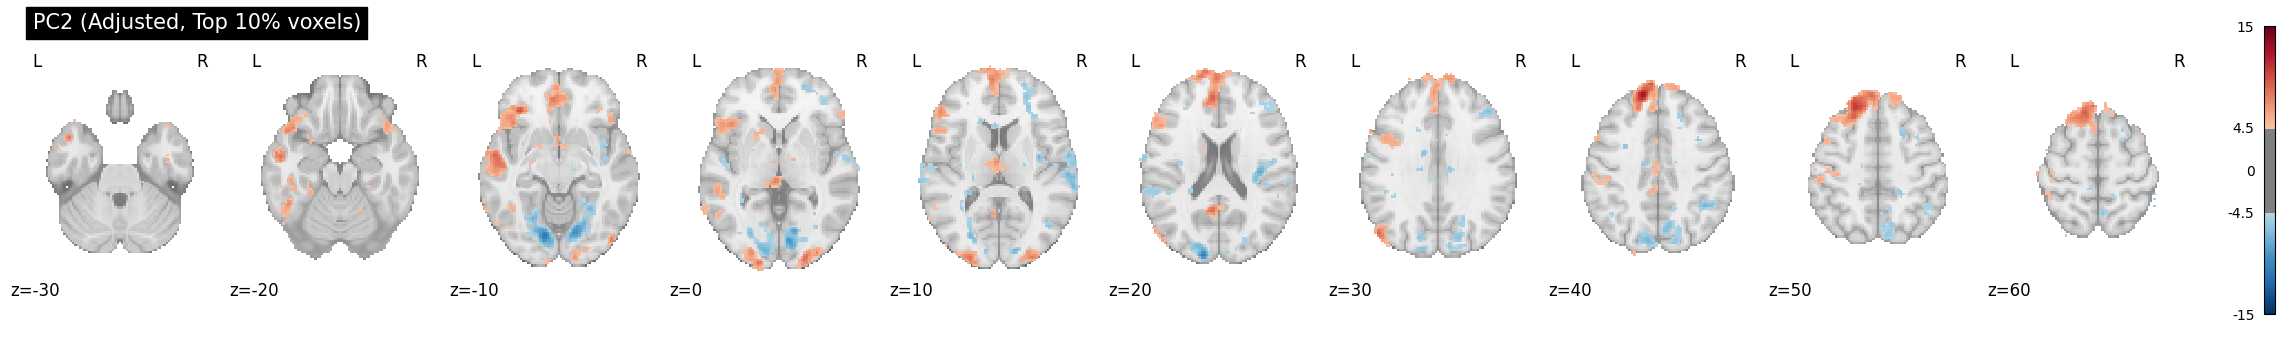

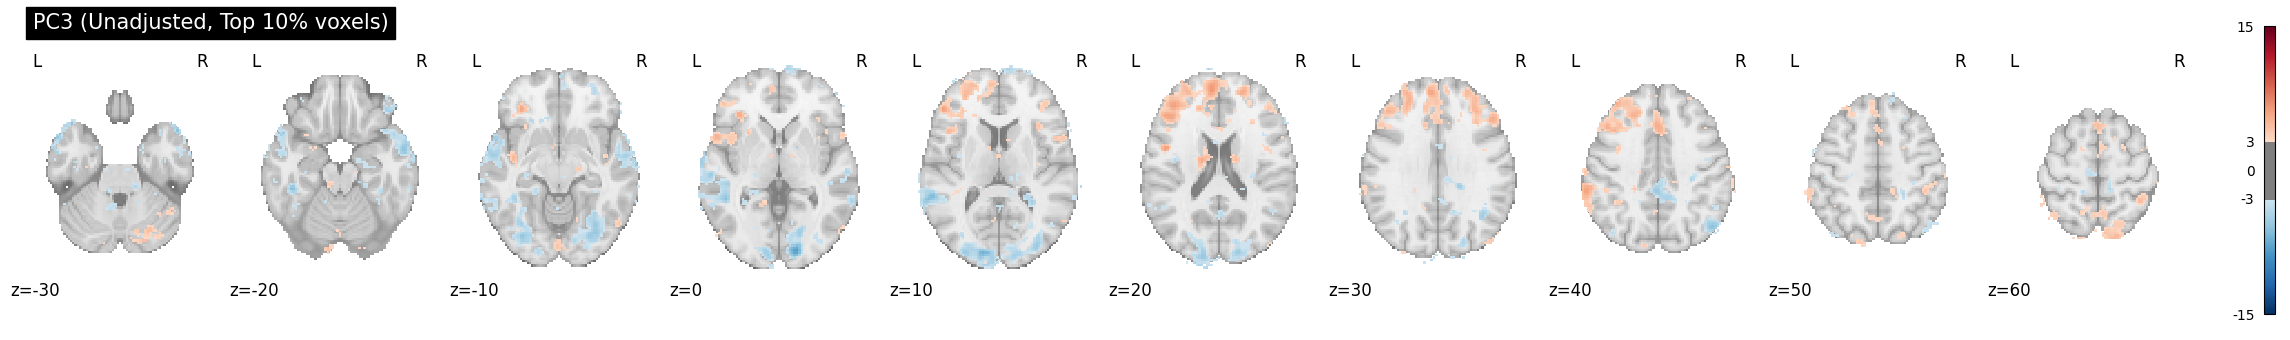

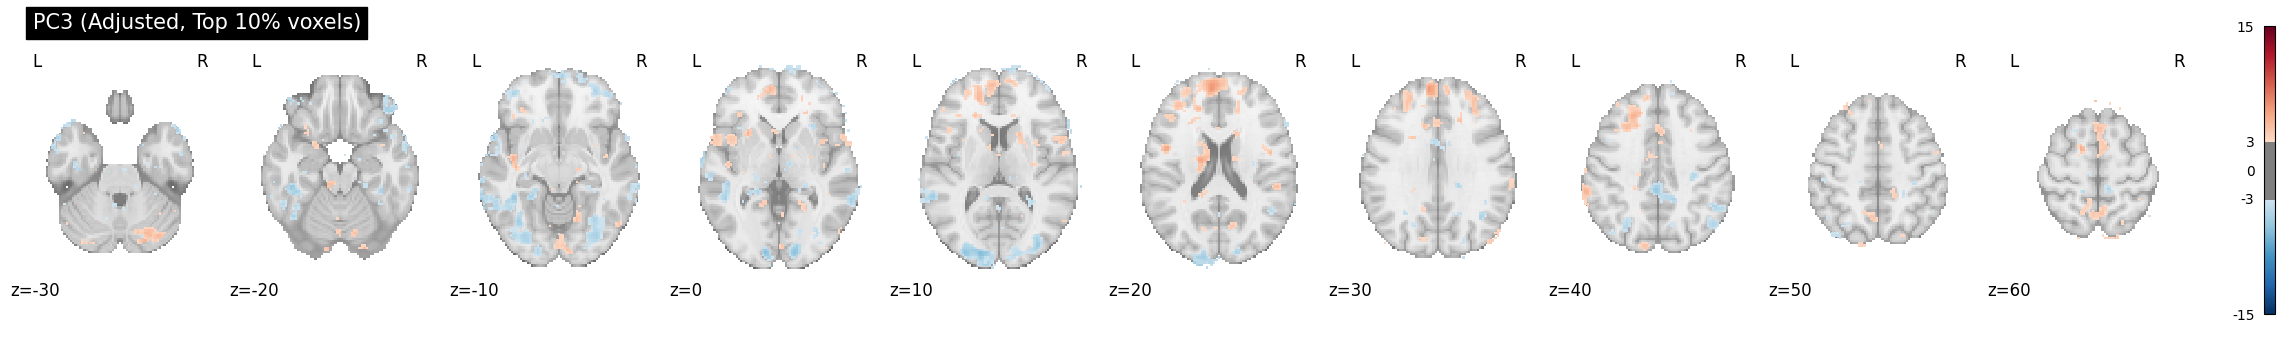

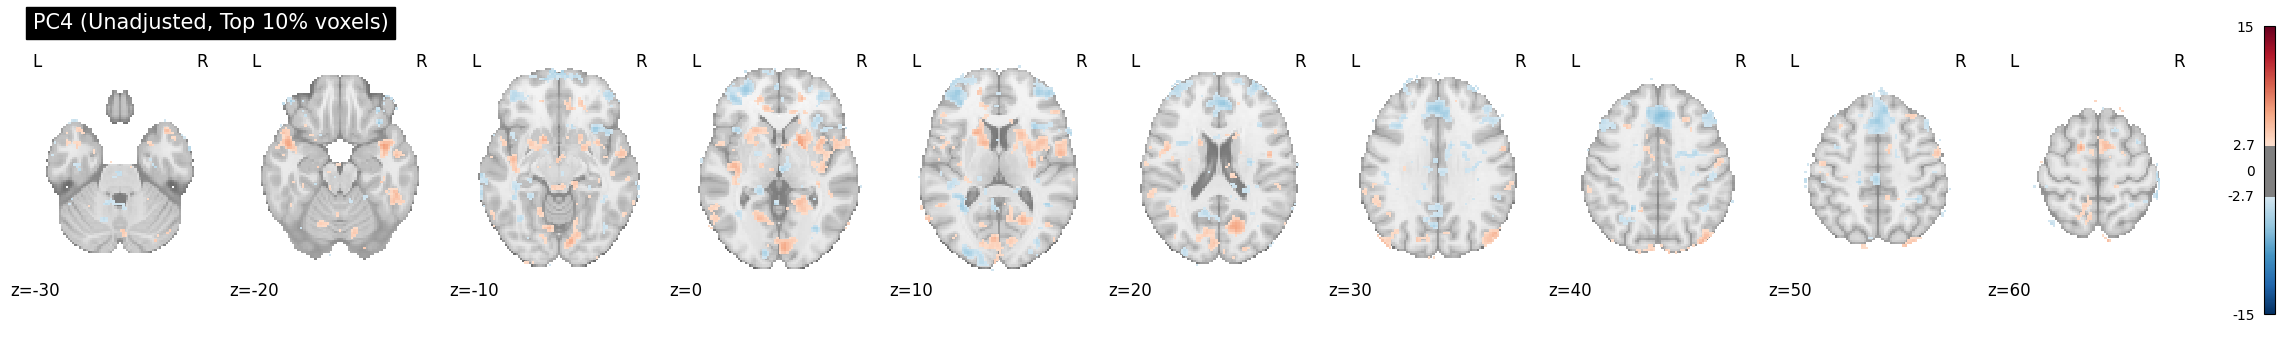

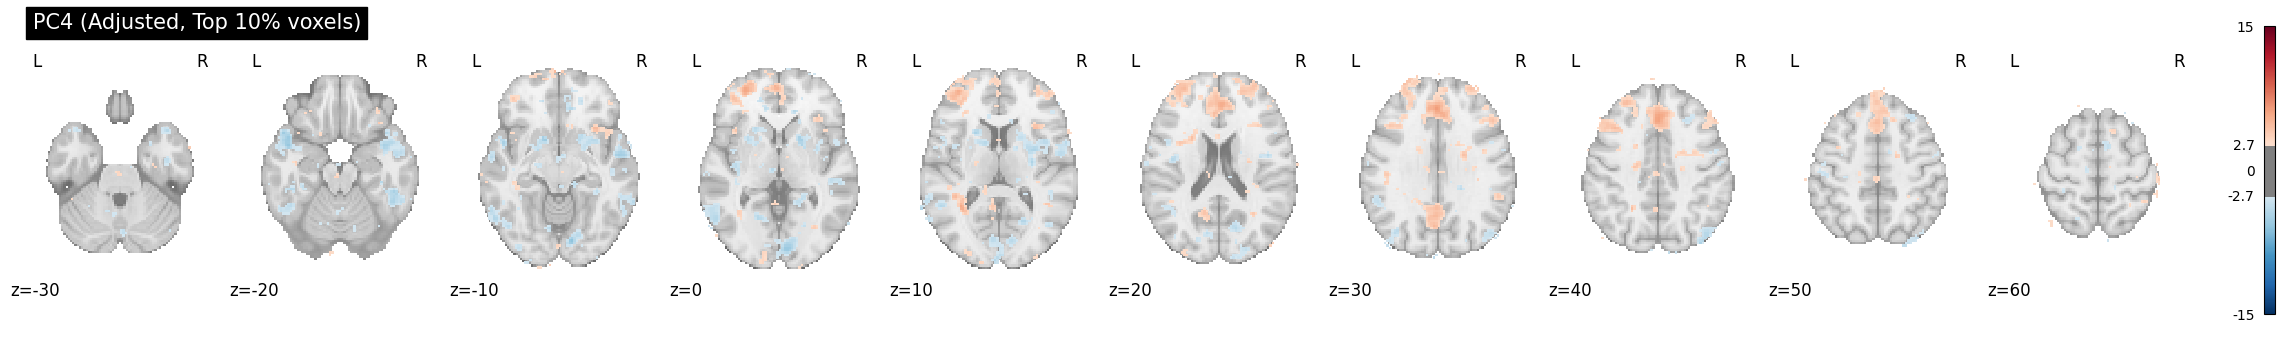

In [14]:
z_slices = list(range(-30, 61, 10))
vmax_val = 15


for pc_idx in range(n_components):
    # 1. Reconstruct 3D PC map in memory
    mask_shape = brain_mask.shape
    pc_map_data = np.zeros(mask_shape)
    pc_map_data[brain_mask > 0] = scores_unscaled[:, pc_idx]

    pc_map_data_adjusted = np.zeros(mask_shape)
    pc_map_data_adjusted[brain_mask > 0] = scores_unscaled_adjusted[:, pc_idx]

    # 2. Determine threshold for top 10% of absolute voxel values
    voxel_values = pc_map_data[brain_mask > 0]
    threshold_val = np.percentile(np.abs(voxel_values), 90)

    voxel_values_adjusted = pc_map_data_adjusted[brain_mask > 0]
    threshold_val_adjusted = np.percentile(np.abs(voxel_values_adjusted), 90)

    # 3. Create NIfTI image
    pc_map_img = nib.Nifti1Image(
        pc_map_data, affine=mask_nifti.affine, header=mask_nifti.header
    )
    pc_map_img_adjusted = nib.Nifti1Image(
        pc_map_data_adjusted, affine=mask_nifti.affine, header=mask_nifti.header
    )
    # 4. Plot top 10% voxels
    display = plot_stat_map(
        pc_map_img,
        display_mode='z',
        cut_coords=z_slices,
        colorbar=True,
        title=f'PC{pc_idx + 1} (Unadjusted, Top 10% voxels)',
        threshold=threshold_val,
        vmax=vmax_val,
    )
    plt.show()

    display = plot_stat_map(
        pc_map_img_adjusted,
        display_mode='z',
        cut_coords=z_slices,
        colorbar=True,
        title=f'PC{pc_idx + 1} (Adjusted, Top 10% voxels)',
        threshold=threshold_val,
        vmax=vmax_val,
    )
    plt.show()